# Cumulative Eigenvector Clustering

What is the impact of each eigenvector to the normalized spectral clustering algorithm? While incrementing $k$, the number of clusters, how do the clusterings change?

In [1]:
from lib.spectral_clustering import spectral_clustering, laplacian_matrix, similarity_matrix
from lib.datasets import gaussian_mixture
from lib.kmeans import kmeans
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from matplotlib import cm
from tqdm import tqdm

## Data generation

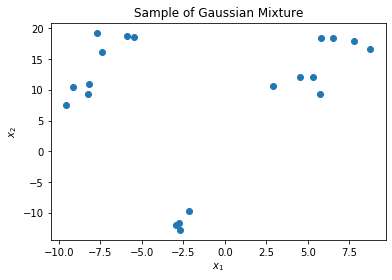

In [2]:
n_gaussians = 5
n_pts = 4
n = n_pts * n_gaussians
d = 2

data = gaussian_mixture(n_gaussians, n_pts, d, centroid_var=10)

plt.scatter(*data.T)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Sample of Gaussian Mixture")
plt.show()

## Extract and Visualize Eigenvectors

In [3]:
_, (evals, evecs) = spectral_clustering(data, k=n, lform="rw", with_eigen=True, metric="e")

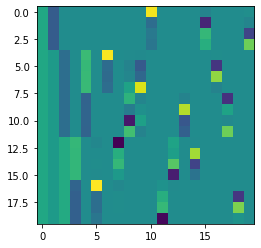

In [4]:
plt.imshow(evecs)
plt.show()

The following plot shows eigenvalue growth rate.
1. If there are $n_{\text{gaussian}}$ clusters, are the first $n_{\text{gaussian}}$-many eigenvalues nearly zero?

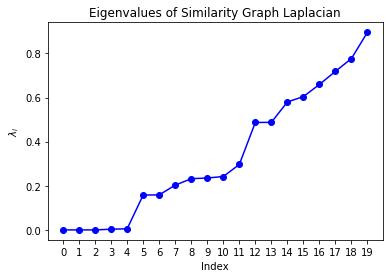

In [5]:
plt.plot(evals, "bo-")
plt.xlabel("Index")
plt.ylabel("$\lambda_i$")
plt.xticks(range(n))
plt.title("Eigenvalues of Similarity Graph Laplacian")
plt.show()

### Cumulative Clusters

Each subplot shows classification decisions using a certain number of eigenvectors of the normalized graph Laplacian. They are cumulative in the sense that plot $(i+1)$ includes all vectors used to cluster plot $(i)$, with an extra one.

In [6]:
cmap = cm.get_cmap("tab20")
unif_colors = [cmap(intensity) for intensity in np.linspace(0, 1, n)]

100%|██████████| 20/20 [00:01<00:00, 11.89it/s]


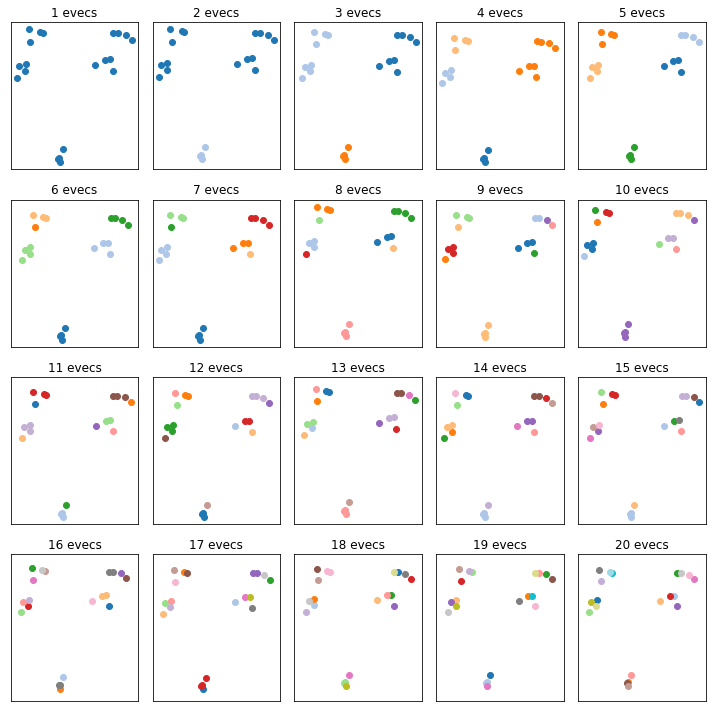

In [16]:
r = n_pts
c = n_gaussians
# r * c = N
for i in tqdm(range(1,n+1)):
    _, assns = kmeans(evecs[:, :i], i, iters=100)
    data_clusters = [ data[assns == clss].T for clss in range(i) ]
    plt.subplot(r, c, i)
    plt.title(f"{i} evecs")
    plt.gca().set_xticks([], [])
    plt.gca().set_yticks([], [])
    
    for j, data_cluster in enumerate(data_clusters):
        plt.scatter(*data_cluster, color=unif_colors[j])
plt.gcf().set_size_inches(10, 10)
plt.tight_layout()
plt.savefig("Cumulative_Eigenvectors.png")
plt.show()

### Individual Eigenvectors

Each subplot shows the classification of points using only the *sign of the components of a partiular eigenvector*. 

Hypothesis: the $n$-th eigenvector is an approximate indicator of the $n$-th most refined cluster.

100%|██████████| 20/20 [00:00<00:00, 62.41it/s]


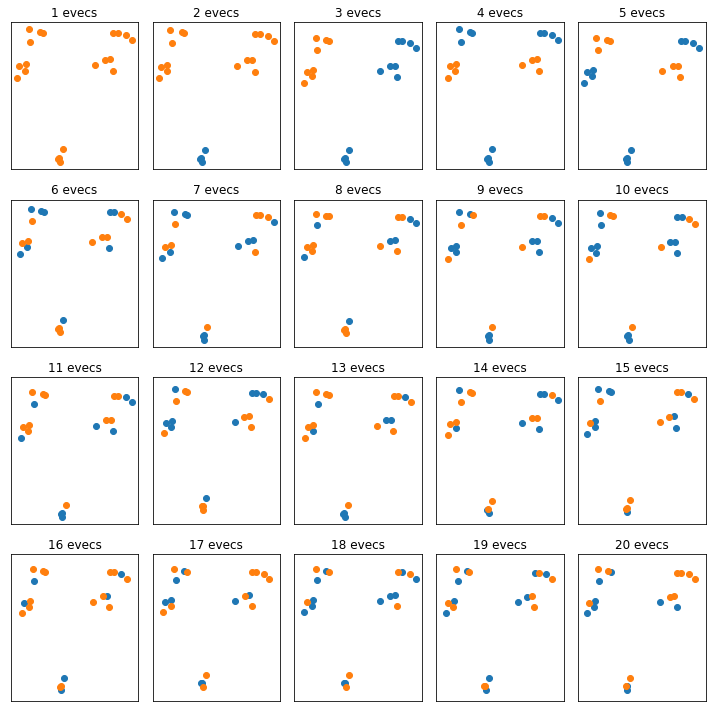

In [15]:
r = n_pts
c = n_gaussians
# r * c = N
for i in tqdm(range(0, n)):
    assns = (evecs[:, i] > 0) 
    data_clusters = [ data[assns == clss, :].T for clss in [0, 1] ] # two class case
    
    plt.subplot(r, c, i+1)
    plt.title(f"{i+1} evecs")
    plt.gca().set_xticks([], [])
    plt.gca().set_yticks([], [])
    
    for j, data_cluster in enumerate(data_clusters):
        plt.scatter(*data_cluster)
plt.gcf().set_size_inches(10, 10)
plt.tight_layout()
plt.savefig("Individual_Eigenvectors.png")
plt.show()

# Classifying Harder Datasets

How well can k-means and spectral clustering identify the moons dataset?

In [18]:
from lib.kmeans import kmeans
from lib.spectral_clustering import spectral_clustering
from sklearn.datasets import make_moons

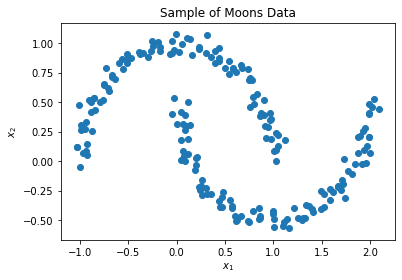

In [26]:
data, _ = make_moons(200, noise=0.05)

plt.scatter(*data.T)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Sample of Moons Data")
plt.show()

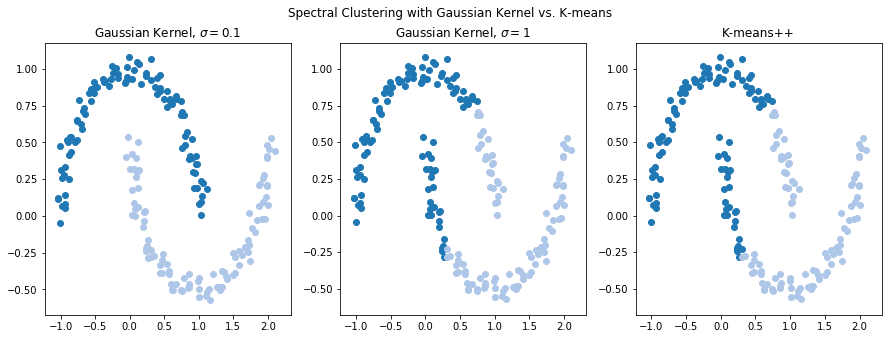

In [43]:
plt.subplot(1, 3, 1)

assns = spectral_clustering(data, k=2, lform="rw", metric="g", s=0.1)

data_clusters = [ data[assns == clss].T for clss in range(n_gaussians) ]
for j, data_cluster in enumerate(data_clusters):
    plt.scatter(*data_cluster, color=unif_colors[j], label=f"{j}")

plt.title("Gaussian Kernel, $\sigma=0.1$")

plt.subplot(1, 3, 2)

assns = spectral_clustering(data, k=2, lform="rw", metric="g", s=1)

data_clusters = [ data[assns == clss].T for clss in range(n_gaussians) ]
for j, data_cluster in enumerate(data_clusters):
    plt.scatter(*data_cluster, color=unif_colors[j], label=f"{j}")

plt.title("Gaussian Kernel, $\sigma=1$")

plt.subplot(1, 3, 3)

_, assns = kmeans(data, k=2)

data_clusters = [ data[assns == clss].T for clss in range(n_gaussians) ]
for j, data_cluster in enumerate(data_clusters):
    plt.scatter(*data_cluster, color=unif_colors[j], label=f"{j}")

plt.title("K-means++")
plt.suptitle("Spectral Clustering with Gaussian Kernel vs. K-means")
plt.gcf().set_size_inches(15, 5)
plt.savefig("Moons_Comparison.png", dpi=120)